In [2]:
# ===============================================================
# Import Libraries
# ===============================================================
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import re


In [10]:
# ===============================================================
# CLIP-Based Clustering Class
# ===============================================================
class CLIPCluster:
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)

        # Technical labels for semantic damage classification
        self.technical_labels = [
            "loose bolt", "rusty bolt", "tight bolt", "damaged tower",
            "metal corrosion", "structural damage", "well-maintained equipment",
            "industrial machinery", "mechanical component", "construction site",
            "bolt connection", "metal structure", "equipment maintenance",
            "corroded surface", "secure fastening", "broken structure"
        ]

    # ===============================================================
    # Extract Visual Features
    # ===============================================================
    def extract_image_features(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            with torch.no_grad():
                inputs = self.processor(images=image, return_tensors="pt").to(self.device)
                image_features = self.model.get_image_features(**inputs)
                image_features = F.normalize(image_features, p=2, dim=1)
            return image_features.cpu().numpy().flatten()
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None

    # ===============================================================
    # Extract Semantic Features
    # ===============================================================
    def extract_semantic_features(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            inputs = self.processor(
                text=self.technical_labels,
                images=image,
                return_tensors="pt",
                padding=True
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = outputs.logits_per_image.softmax(dim=1)
            return probs.cpu().numpy().flatten()
        except Exception as e:
            print(f"Error in semantic extraction {image_path}: {e}")
            return None

    # ===============================================================
    # Get All Image Features + Dominant Labels
    # ===============================================================
    def get_all_image_features(self, folder_path):
        image_files, all_features, dominant_labels = [], [], []

        for file in sorted(os.listdir(folder_path)):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(folder_path, file)
                vis_feat = self.extract_image_features(image_path)
                sem_feat = self.extract_semantic_features(image_path)

                if vis_feat is not None and sem_feat is not None:
                    image_files.append(file)
                    # Combine visual and semantic features for better clustering
                    combined_feat = np.concatenate([vis_feat, sem_feat])
                    all_features.append(combined_feat)
                    # Determine and store the dominant label
                    label_idx = np.argmax(sem_feat)
                    dominant_labels.append(self.technical_labels[label_idx])
                else:
                    print(f"Skipping {file} due to feature extraction error")

        return image_files, np.array(all_features), dominant_labels

    # ===============================================================
    # Perform Clustering
    # ===============================================================
    def perform_clustering(self, features, n_clusters=5):
        # Using 'kmeans' as the default method
        pca = PCA(n_components=min(50, features.shape[1]))
        reduced_features = pca.fit_transform(features)
        
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = clusterer.fit_predict(reduced_features)
        
        return cluster_labels, reduced_features

    # ===============================================================
    # Analyze Cluster Composition
    # ===============================================================
    def analyze_clusters(self, image_files, cluster_labels, dominant_labels):
        # No need to pass 'features' here if it's not used in the final df
        df = pd.DataFrame({
            'image_name': image_files,
            'cluster_id': cluster_labels,
            'dominant_label': dominant_labels
        })

        cluster_summary = []
        for cluster_id in sorted(df['cluster_id'].unique()):
            cluster_df = df[df['cluster_id'] == cluster_id]
            # Find the most frequent label in this cluster to represent it
            cluster_main_label = cluster_df['dominant_label'].mode()[0]
            
            cluster_summary.append({
                'cluster_id': cluster_id,
                'cluster_main_label': cluster_main_label,
                'size': len(cluster_df),
                'images': list(cluster_df['image_name'])
            })
        return df, cluster_summary

    # ===============================================================
    # Create Folders Based on CLUSTERS and Labels (Corrected Logic)
    # ===============================================================
    def _slugify(self, text):
        """Helper function to create a clean, file-safe string."""
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s-]', '', text)
        text = re.sub(r'[\s-]+', '_', text).strip('_')
        return text

    def create_cluster_folders(self, source_folder, output_base, results_df):
        Path(output_base).mkdir(parents=True, exist_ok=True)

        # Iterate through each cluster group found
        for cluster_id in sorted(results_df['cluster_id'].unique()):
            # Get all data for the current cluster
            cluster_df = results_df[results_df['cluster_id'] == cluster_id]
            
            # **CRITICAL LOGIC**: Find the most common label for THIS cluster
            # This label will define the folder name.
            main_label = cluster_df['dominant_label'].mode()[0]
            slug_label = self._slugify(main_label)
            
            # Create folder name combining cluster_id and its dominant label
            folder_name = f"cluster_{cluster_id}_{slug_label}"
            cluster_folder_path = Path(output_base) / folder_name
            cluster_folder_path.mkdir(exist_ok=True)

            # Reset counter for file renaming within this new folder
            file_counter = 0
            # Copy and rename images belonging to THIS cluster into the new folder
            for index, row in cluster_df.iterrows():
                file_counter += 1
                src_path = Path(source_folder) / row['image_name']
                
                # Create a new, clean file name
                file_extension = Path(row['image_name']).suffix
                new_name = f"{slug_label}_{file_counter:02d}{file_extension}"
                dst_path = cluster_folder_path / new_name
                
                if src_path.exists():
                    shutil.copy2(src_path, dst_path)

    # ===============================================================
    # Visualize Clusters (Improved Layout)
    # ===============================================================
    def visualize_clusters(self, features_reduced, cluster_labels, output_path):
        plt.figure(figsize=(18, 8)) # Wider figure for better side-by-side view

        # --- Scatter Plot of Clusters ---
        plt.subplot(1, 2, 1) # Changed to side-by-side
        scatter = plt.scatter(features_reduced[:, 0], features_reduced[:, 1],
                              c=cluster_labels, cmap='viridis', alpha=0.8, s=70)
        plt.title('CLIP Feature Clustering', fontsize=14)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        # Add a legend to identify clusters
        handles, _ = scatter.legend_elements()
        legend_labels = [f'Cluster {i}' for i in range(len(handles))]
        plt.legend(handles, legend_labels, title="Clusters")

        # --- Bar Chart of Cluster Sizes ---
        plt.subplot(1, 2, 2) # Changed to side-by-side
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Image Distribution per Cluster', fontsize=14)
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
        plt.show()


In [11]:
# ===============================================================
# Report Generation
# ===============================================================
def generate_cluster_report(cluster_summary, output_base):
    report_path = Path(output_base) / "clustering_analysis_report.txt"
    with open(report_path, "w", encoding="utf-8") as f:
        f.write("CLUSTERING ANALYSIS REPORT\n")
        f.write("=" * 60 + "\n\n")
        for cluster_info in cluster_summary:
            f.write(f"--- Cluster {cluster_info['cluster_id']} ---\n")
            f.write(f"   Dominant Semantic Label: '{cluster_info['cluster_main_label']}'\n")
            f.write(f"   Number of Images: {cluster_info['size']}\n")
            f.write(f"   Sample Files: {', '.join(cluster_info['images'][:5])}\n\n")
    print(f"Full text report saved to: {report_path}")

In [12]:
# ===============================================================
# Main Execution (Corrected Flow)
# ===============================================================
def main():
    # --- Configuration ---
    source_folder = "/home/fatemeh/Desktop/yes/Downloads/IMAGE-20251029T142813Z-1-001/IMAGE"
    output_base = "/home/fatemeh/Desktop/yes/Downloads/IMAGE-20251029-1-001/IMAGE/clustered_results_fixed"
    
    # --- Execution ---
    clusterer = CLIPCluster()

    print("Step 1: Extracting features from images...")
    image_files, features, dominant_labels = clusterer.get_all_image_features(source_folder)
    print(f"-> Extracted features from {len(image_files)} images.\n")
    if not image_files:
        print("Execution stopped: No images found in the source folder.")
        return None, None

    # Dynamically determine number of clusters
    n_clusters = min(8, len(image_files) // 3)
    n_clusters = max(3, n_clusters)
    print(f"Step 2: Performing clustering with {n_clusters} clusters...")
    cluster_labels, reduced_feats = clusterer.perform_clustering(features, n_clusters=n_clusters)
    print("-> Clustering complete.\n")

    print("Step 3: Analyzing cluster results...")
    # This dataframe is now the single source of truth
    results_df, summary = clusterer.analyze_clusters(image_files, cluster_labels, dominant_labels)
    print("-> Analysis complete.\n")

    print("Step 4: Creating folders and organizing images...")
    # Pass the dataframe to the folder creation function
    clusterer.create_cluster_folders(source_folder, output_base, results_df)
    print("-> Folder organization complete.\n")

    print("Step 5: Generating visualizations...")
    viz_path = os.path.join(output_base, "clustering_visualization.png")
    clusterer.visualize_clusters(reduced_feats, cluster_labels, viz_path)
    print(f"-> Visualization saved to {viz_path}\n")

    print("Step 6: Saving final reports...")
    # Save CSV report
    csv_report_path = os.path.join(output_base, "clustering_results.csv")
    results_df.to_csv(csv_report_path, index=False)
    # Save text summary report
    generate_cluster_report(summary, output_base)
    print(f"-> CSV report saved to {csv_report_path}\n")

    print("="*60)
    print(" Clustering process completed successfully!")
    print(f"   Output saved to: {output_base}")
    print("="*60)
    return results_df, summary

Using device: cpu
Step 1: Extracting features from images...
-> Extracted features from 90 images.

Step 2: Performing clustering with 8 clusters...
-> Clustering complete.

Step 3: Analyzing cluster results...
-> Analysis complete.

Step 4: Creating folders and organizing images...
-> Folder organization complete.

Step 5: Generating visualizations...


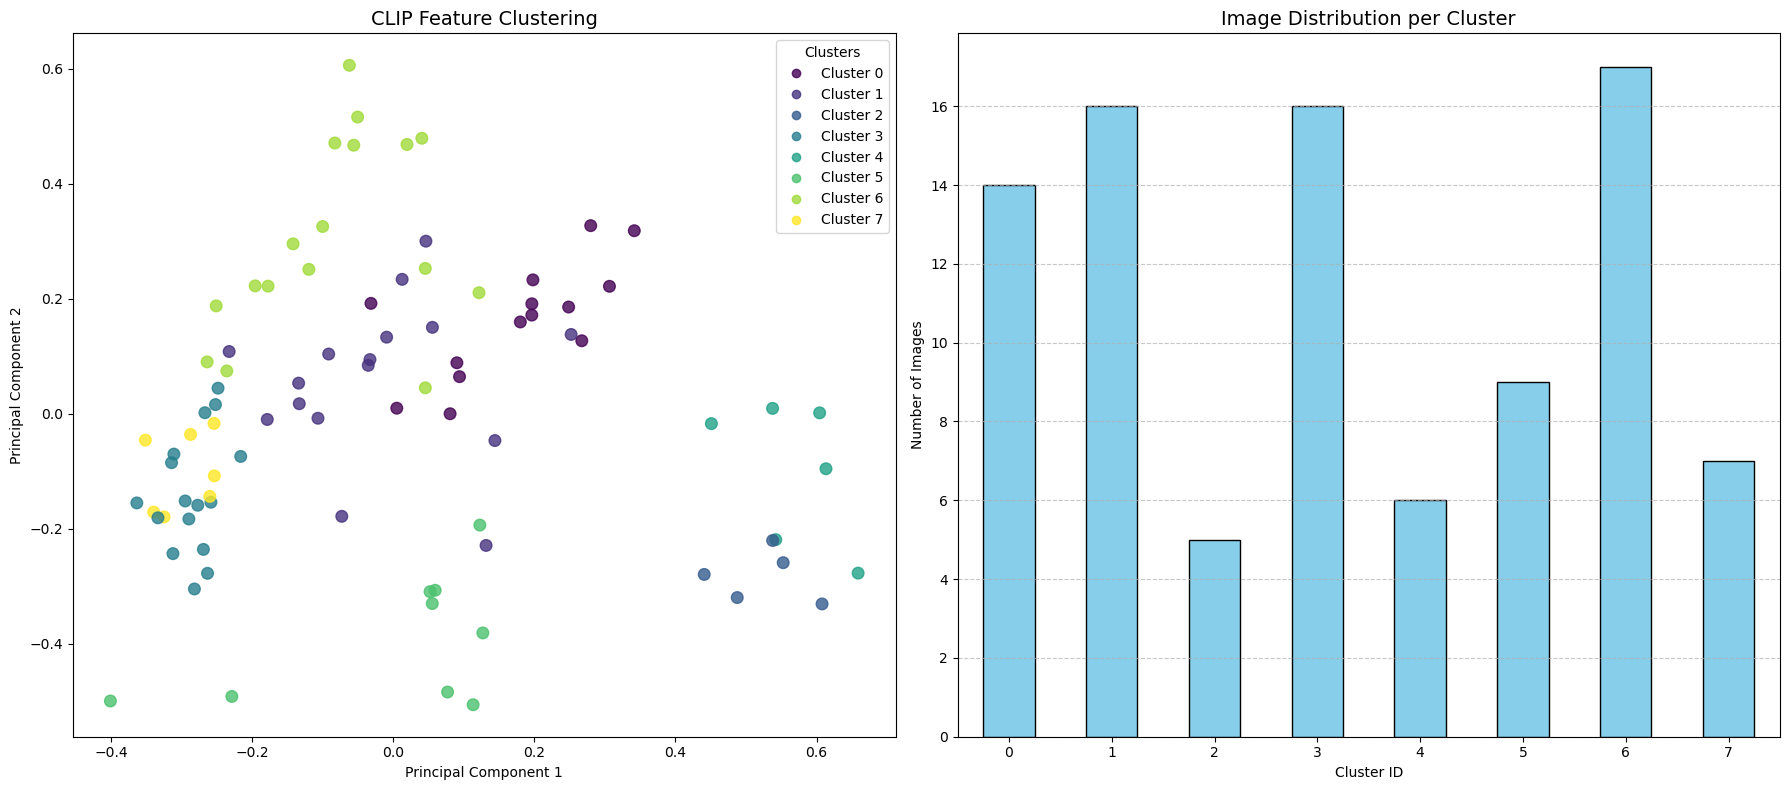

-> Visualization saved to /home/fatemeh/Desktop/yes/Downloads/IMAGE-20251029T142813Z-1-001/IMAGE/clustered_results_fixed/clustering_visualization.png

Step 6: Saving final reports...
Full text report saved to: /home/fatemeh/Desktop/yes/Downloads/IMAGE-20251029T142813Z-1-001/IMAGE/clustered_results_fixed/clustering_analysis_report.txt
-> CSV report saved to /home/fatemeh/Desktop/yes/Downloads/IMAGE-20251029T142813Z-1-001/IMAGE/clustered_results_fixed/clustering_results.csv

✅ Clustering process completed successfully!
   Output saved to: /home/fatemeh/Desktop/yes/Downloads/IMAGE-20251029T142813Z-1-001/IMAGE/clustered_results_fixed


In [14]:
# ===============================================================
# Entry Point
# ===============================================================
if __name__ == "__main__":
    # The 'if' block makes the script runnable from command line
    main()